In [50]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

In [51]:
data = yf.download('AAPL',interval='1D',period='5y')
data.head(5)

/var/folders/wq/n2q2m9w17lg_p99b5c2yc2dm0000gn/T/ipykernel_82146/2214729564.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL',interval='1D',period='5y')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-07-29,92.385460,92.570155,91.095039,91.131490,90329200
2020-07-30,93.503326,93.607822,91.148488,91.556756,158130000
2020-07-31,103.292053,103.442723,98.008853,100.011320,374336800
2020-08-03,105.894775,108.519359,104.878965,105.177871,308151200
2020-08-04,106.601936,107.695514,105.360114,106.084308,173071600


In [52]:
Data = data['Close']
Data.head(5)

Ticker,AAPL
Date,
2020-07-29,92.385460
2020-07-30,93.503326
2020-07-31,103.292053
2020-08-03,105.894775
2020-08-04,106.601936


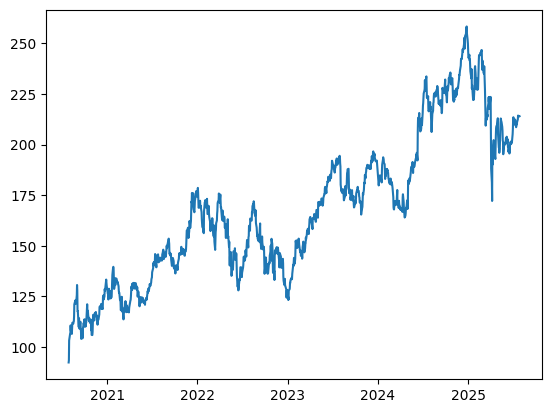

In [53]:
plt.plot(Data)

In [54]:
Data.isnull().sum()

Ticker
AAPL    0
dtype: int64

In [55]:
Data = data.reset_index()['Close']
Data

Ticker,AAPL
0,92.385460
1,93.503326
2,103.292053
3,105.894775
4,106.601936
...,...
1250,214.399994
1251,214.149994
1252,213.759995
1253,213.880005


In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
Data_scaled = scaler.fit_transform(np.array(Data).reshape(-1, 1))
Data_scaled


array([[0.        ],
       [0.00673368],
       [0.06569793],
       ...,
       [0.73112253],
       [0.73184544],
       [0.73286945]], shape=(1255, 1))

In [57]:
Data_scaled = torch.tensor(Data_scaled, dtype=torch.float32)


In [58]:
train_size = (int)(len(Data_scaled) * 0.65)
train_data = Data_scaled[:train_size]
test_data = Data_scaled[train_size:len(Data_scaled)]
print(train_data.shape,test_data.shape)

torch.Size([815, 1]) torch.Size([440, 1])


In [59]:
def split(dataset,block_size):
    X_data = []
    Y_data = []
    for i in range(len(dataset)-block_size):
        a = dataset[i:i+block_size]
        X_data.append(a)
        Y_data.append(dataset[i+block_size])
    return torch.stack(X_data),torch.stack(Y_data)

In [60]:
block_size = 100
X_train,Y_train = split(train_data,block_size)
X_test,Y_test = split(test_data,block_size)
X_train.shape,Y_train.shape

(torch.Size([715, 100, 1]), torch.Size([715, 1]))

In [61]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

/var/folders/wq/n2q2m9w17lg_p99b5c2yc2dm0000gn/T/ipykernel_82146/4150544819.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/wq/n2q2m9w17lg_p99b5c2yc2dm0000gn/T/ipykernel_82146/4150544819.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
/var/folders/wq/n2q2m9w17lg_p99b5c2yc2dm0000gn/T/ipykernel_82146/4150544819.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.

In [62]:
input_size = int(X_train.shape[2])
hidden_size = 100
num_layers = 5
lr = 0.001
batch_size = 32

In [63]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_layers = nn.ModuleList()
        for i in range(num_layers):
            layer_input_size = input_size if i == 0 else hidden_size
            self.lstm_layers.append(
                nn.LSTM(
                    input_size=layer_input_size,
                    hidden_size=hidden_size,
                    batch_first=True,
                    dropout=0.3
                )
            )
        self.linear = nn.Linear(hidden_size, 1)


    def forward(self, x):
            # batch_size = x.size(0)
            for lstm in self.lstm_layers:
                x, _ = lstm(x)      # LSTM returns (output, (h_n, c_n))
            last_output = x[:, -1, :]    # Take the last timestep's output 
            return self.linear(last_output)


In [64]:
import torch.optim as optim
from torch import nn

model = LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=lr) 


/opt/anaconda3/envs/ml2-env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [65]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    epoch_loss = 0.0

    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_train[indices]
        batch_y = Y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

   
    if epoch % 10 == 0:
        print(f"epoch: {epoch} , Loss: {epoch_loss/len(X_train)}")

# Evaluation
model.eval()
with torch.no_grad():
    predicted = model(X_test).numpy()

epoch: 0 , Loss: 0.0008386059559985891
epoch: 10 , Loss: 5.989600562366781e-05
epoch: 20 , Loss: 2.518868655083584e-05
epoch: 30 , Loss: 1.5514735433670296e-05
epoch: 40 , Loss: 1.0089184808010769e-05
epoch: 50 , Loss: 1.0593462095537282e-05
epoch: 60 , Loss: 1.0906634840078756e-05
epoch: 70 , Loss: 9.169250664014656e-06
epoch: 80 , Loss: 9.549827330381042e-06
epoch: 90 , Loss: 9.006460789929736e-06


In [66]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test)
    y_pred = y_pred_scaled.detach().numpy()

    y_pred_actual = scaler.inverse_transform(y_pred)

    # Optional: do the same for the ground truth to calculate MSE or plot
    y_test_actual = scaler.inverse_transform(Y_test.numpy())


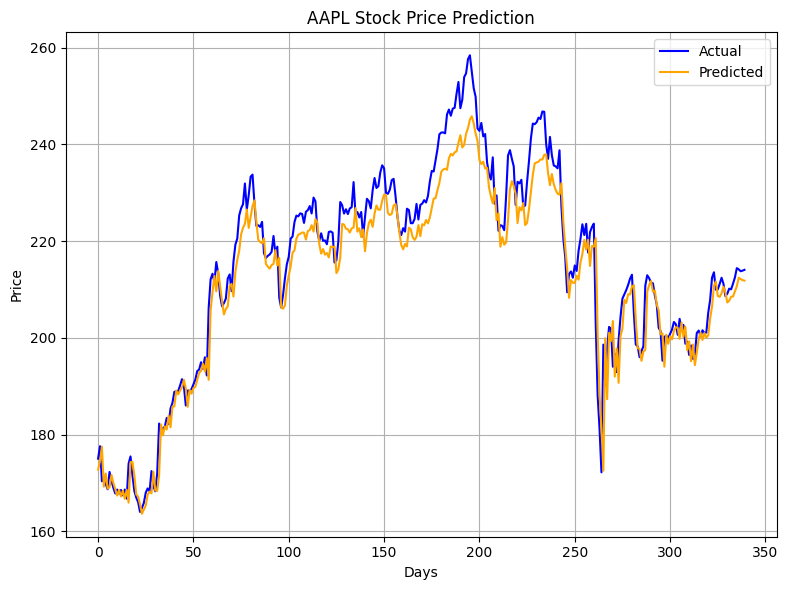

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(y_pred_actual, label='Predicted', color='orange')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
last_20_days = torch.tensor(Data_scaled[-block_size:], dtype=torch.float32).view(1, block_size, 1)

model.eval()
with torch.no_grad():
    next_pred = model(last_20_days).item()

next_price = scaler.inverse_transform([[next_pred]])
print(f"Predicted next day's price: ${next_price[0][0]:.2f}")


Predicted next day's price: $212.02


/var/folders/wq/n2q2m9w17lg_p99b5c2yc2dm0000gn/T/ipykernel_82146/58598884.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_20_days = torch.tensor(Data_scaled[-block_size:], dtype=torch.float32).view(1, block_size, 1)
